# WIP: Low rank updates to the mass matrix

We use the stochastic volatility model from the pymc3 examples as our model. See the notebook for more info.

In Hamiltonian MCMC we can influence the performance of the sampler by choosing a mass matrix $M$ that approximates the posterior precision. During sampling we need to draw samples from $N(0, M)$ and compute the energy $\frac12 x^TM^{-1}x$. Since using a dense matrix is very expensive, we usually just use a diagonal matrix.

This notebook is an experiment in using low rank updates to a diagonal matrix as mass matrix
$$
M = D + U\Sigma U^T,
$$
where $U\in \mathbf{R}^{n\times p}$ and $p \ll n$. We can use the Woodbury identity to solve $M^{-1}x$ and a nice trick described in detail in [1] to compute a factorization of $M$ in $O(np^2)$.

Given an entimate of the inverse of the correlation matrix $P$ we can compute a (partial) eigen-decomposition and set 
$$
M = D^{-\frac12}(\lambda I + U\Sigma U^T)D^{-\frac12},
$$
where $D$ is a diagonal matrix containing the posterior variances and $\Sigma$ contains the largest eigenvalues of $P$. We choose $\lambda$ such that $tr(\lambda I + U\Sigma U^T) = n\lambda + \sum \Sigma_{ii} = tr(P)$.

Using the sample correlation matrix to compute $P$ does not seem to work well, because we need the small eigenvalues of the correlation matrix. The (mean) hessian would be another option, but is tends to be indefinite. Instead I noticed that it seems to work if we use the outer product of the gradients.

(Maybe we can combine them somehow? Get the small eigenvalues of $P$ from the correlation matrix and the large eigenvalues from the gradients...)

In the problem at hand this gives about twice the number of effective samples per second as using a diagonal matrix and 

Notes:

- Could we combine the sample covariance and the outer product of the gradients somehow to get an entimate of both large and small eigenvalues? But how do we combine them...

- We could use iterative algorithms to find the eigenvalues of large matrices without having to store the whole matrix. But if the dimension is high enough for this to matter, I guess the eigenvalues of the sample cov won't be good any more anyway.

- [1] also extends the factorization algorithm to hierarchical matrices. That might be useful, too.

[1] S. Ambikasaran, M. O’Neil, and K. R. Singh, “Fast symmetric factorization of
    hierarchical matrices with applications,” arXiv:1405.0223 [physics, stat], May 2014.


In [61]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy import optimize, linalg
from pymc3.theanof import floatX

import seaborn as sb
import matplotlib.pyplot as plt
from scipy import linalg
import time

%matplotlib inline

## Build Model

First we load some daily returns of the S&P 500.

In [62]:
n = 400
returns = np.genfromtxt(pm.get_data("SP500.csv"))[-n:]
returns[:5]

array([-0.00637 , -0.004045, -0.02547 ,  0.005102, -0.047733])

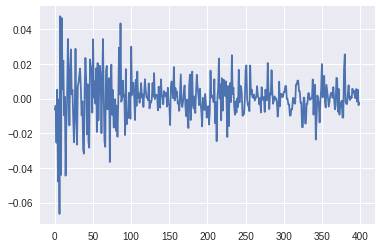

In [63]:
plt.plot(returns)

Specifying the model in pymc3 mirrors its statistical specification. 

In [11]:
model = pm.Model()
with model:
    sigma = pm.Exponential('sigma', floatX(1./.02), testval=floatX(.1))

    nu = pm.Exponential('nu', floatX(1./10))
    #s = GaussianRandomWalk('s', sigma**-2, shape=n)
    a = pm.Flat('a')
    s = pm.Normal('s', mu=0, sd=sigma, shape=n)
    s = a + s.cumsum()

    r = pm.StudentT('r', nu, lam=pm.math.exp(-2*s), observed=floatX(returns))

In [75]:
model.ndim

403

## Fit Model

In [12]:
with model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -1,237.1: 100%|██████████| 200000/200000 [01:00<00:00, 3309.92it/s]
Finished [100%]: Average Loss = -1,237
100%|██████████| 3000/3000 [00:53<00:00, 56.53it/s]


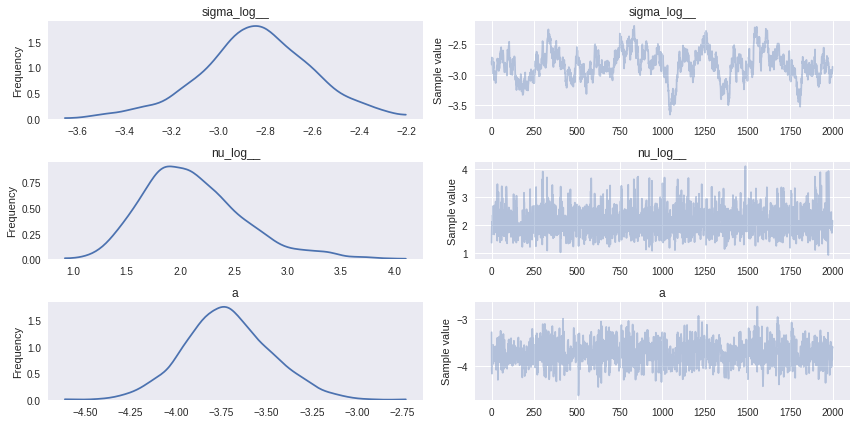

In [69]:
_ = pm.traceplot(trace, model.vars[:-1])

In [14]:
samples = np.array([model.dict_to_array(p) for p in trace])
cov = np.cov(samples.T)
stds = np.sqrt(np.diag(cov))
corr = cov.copy()
corr[:] /= stds[None, :]
corr[:] /= stds[:, None]

In [72]:
g = np.array([model.dlogp_array(model.dict_to_array(p)) * stds for p in trace])
h_grad = g.T @ g
h_grad[:] /= len(g)

In [49]:
#corr_ = linalg.inv(h_grad)
#cov_[:] *= stds[None, :]
#cov_[:] *= stds[:, None]

with model:
    args = {'scaling': floatX(cov), 'is_cov': True}
    start = time.time()
    step = pm.NUTS(**args)
    trace_cov = pm.sample(10000, tune=1000, init=None, step=step, njobs=2)
    time_cov = time.time() - start

100%|██████████| 11000/11000 [12:10<00:00, 15.07it/s] 


In [76]:
with model:
    args = {'scaling': floatX(stds ** 2), 'is_cov': True}
    start = time.time()
    step = pm.NUTS(**args)
    trace_stds = pm.sample(10000, tune=1000, init=None, step=step, njobs=2)
    time_stds = time.time() - start

100%|██████████| 11000/11000 [05:56<00:00, 30.89it/s]


In [80]:
eigs, u = linalg.eigh(h_grad, eigvals=(model.ndim - 3, model.ndim - 1))
m = u @ np.diag(eigs) @ u.T
lam = (np.trace(h_grad) - np.trace(m)) / model.ndim
diag = np.ones(len(stds)) * lam
pot = pm.step_methods.hmc.quadpotential.LowRankUpdatePotential(stds, diag, u, eigs)

with model:
    args = {'potential': pot}#, 'profile': True}
    start = time.time()
    step = pm.NUTS(**args)
    trace_rank = pm.sample(10000, tune=1000, init=None, step=step, njobs=2)
    time_rank = time.time() - start

100%|██████████| 11000/11000 [02:00<00:00, 91.04it/s] 


In [52]:
min(v.min() for v in pm.effective_n(trace_cov).values())

279.0

In [77]:
min(v.min() for v in pm.effective_n(trace_stds).values())

311.0

In [81]:
min(v.min() for v in pm.effective_n(trace_rank).values())

251.0

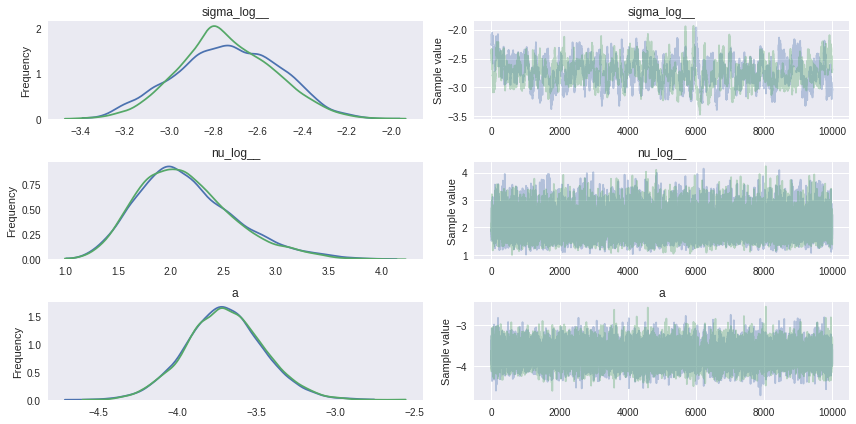

In [74]:
_ = pm.traceplot(trace_rank, model.vars[:-1])

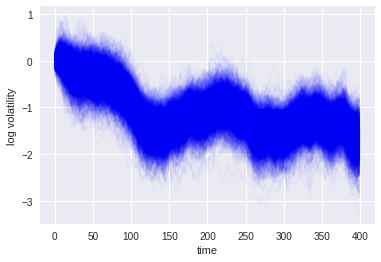

In [60]:
plt.plot(trace_rank['s'].cumsum(axis=-1)[::10].T, 'b', alpha=.03);
plt.xlabel('time')
_ = plt.ylabel('log volatility')

Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

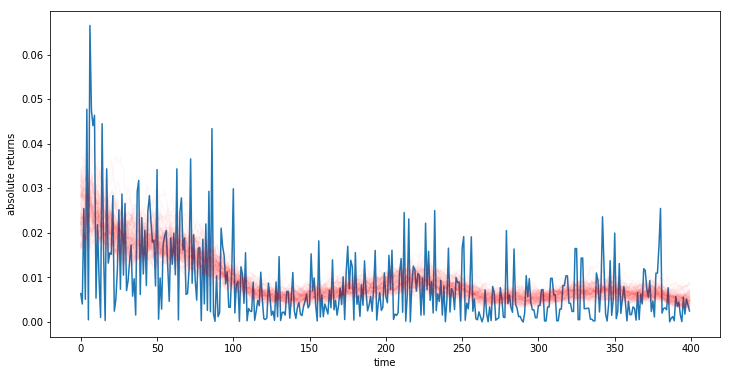

In [12]:
plot(np.abs(returns))
plot(np.exp(trace[s][::10].T), 'r', alpha=.03);
sd = np.exp(trace[s].T)
xlabel('time')
ylabel('absolute returns')

## References

1. Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](http://arxiv.org/abs/1111.4246). 